In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [2]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1896, #1838 
                   1921, 628]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 1831, 1838, 1899, 1911, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]


generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]

raw = load_mm94_stations(train_station_id + test_station_id + generate_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis, interpol_freq=20)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_underroad', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)

generated = data[data['station_id'].isin(generate_station_id)]
generated = generated.reset_index(drop=True)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 2min 13s, sys: 15.7 s, total: 2min 29s
Wall time: 2min 29s


## Feature selection

In [3]:
from preprocessing import create_feature_df
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from functools import partial

In [4]:
point = pd.Timestamp(2015, 6, 1)

params_df = {}  
params_df['target'] = 'data_t_road'
params_df['variables'] = ['data_t_air', 'data_t_road', 'data_t_underroad', 
                          'data_pressure', 'data_dampness']
params_df['interpol_freq'] = 20
params_df['lag_list'] = (1, 2, 3, 4, 5, 6, 7, 8)
params_df['diff_list'] = ((1, 2), (2, 3), (3, 4), (4, 5), (5, 6))
params_df['coordinates'] = True
params_df['solar_angles'] = True
params_df['road_id'] = False
params_df['day_of_year'] = True
params_df['month'] = False
params_df['hour'] = True
params_df['post_process'] = False

df_train = create_feature_df(train[train['date_time_utc'] < point], **params_df)
df_valid = create_feature_df(train[train['date_time_utc'] >= point], **params_df)
df_test = create_feature_df(test, **params_df)

In [5]:
main_cols = ('data_t_road', 'data_t_air', 'data_t_underroad', 'data_pressure', 'data_dampness')
features = [col for col in df_train if col.startswith('data_')]
features = [col for col in features if col not in (main_cols)]
target = [col for col in df_train if col.startswith('target_')][0]

X_train = np.array(df_train[features].values)
y_train = np.array(df_train[target].values)

X_valid = np.array(df_valid[features].values)
y_valid = np.array(df_valid[target].values)

X_test = np.array(df_test[features].values)
y_test = np.array(df_test[target].values)

lgb_train = lgb.Dataset(X_train, y_train, feature_name=features)
lgb_val = lgb.Dataset(X_valid, y_valid, reference=lgb_train, feature_name=features)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, feature_name=features)

## Train model

In [6]:
df = df_train

baseline_mse = mean_squared_error(df.data_t_road_lag_20, df.target_t_road)
baseline_mae = mean_absolute_error(df.data_t_road_lag_20, df.target_t_road)

print('MAE: {0: .2f} \nMSE: {1: .2f}'.format(baseline_mae, baseline_mse))

MAE:  0.32 
MSE:  0.33


In [ ]:
#	train's l1: 0.114561	valid's l1: 0.117564	test's l1: 0.129071

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l1',
    'num_leaves': 50,
    'learning_rate': 0.15,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    #'lambda_l1': 1.0,
    #'lambda_l2': 2.0,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=6000,
                valid_sets=(lgb_train, lgb_val, lgb_test),
                valid_names=('train', 'valid', 'test'),
                verbose_eval=300,)

[300]	train's l1: 0.168071	valid's l1: 0.145595	test's l1: 0.173714
[600]	train's l1: 0.155309	valid's l1: 0.138591	test's l1: 0.166373
[900]	train's l1: 0.147491	valid's l1: 0.13522	test's l1: 0.163001
[1200]	train's l1: 0.142259	valid's l1: 0.134058	test's l1: 0.161735
[1500]	train's l1: 0.137594	valid's l1: 0.132571	test's l1: 0.160311
[1800]	train's l1: 0.133776	valid's l1: 0.13197	test's l1: 0.1596
[2100]	train's l1: 0.130126	valid's l1: 0.13108	test's l1: 0.158817
[2400]	train's l1: 0.1269	valid's l1: 0.130512	test's l1: 0.158261
[2700]	train's l1: 0.12381	valid's l1: 0.129819	test's l1: 0.15766
[3000]	train's l1: 0.121197	valid's l1: 0.129527	test's l1: 0.157391
[3300]	train's l1: 0.118584	valid's l1: 0.129124	test's l1: 0.156936


In [ ]:
z = list(zip(features, list(gbm.feature_importance())))
z.sort(key=lambda item: item[1], reverse=True)
z[:5]

## Save Best Model

import pickle

f = open('/mnt/HARD/MinMax94/models/anomaly_detection/detector_t_road.pickle','wb')                                                                                                                                                                                                                                                           
pickle.dump(gbm,f)                                                                                                                                                                                                                                                                        
f.close()

## Select Threshold

### Generate anomalies

In [ ]:
from score import calc_precision, calc_recall, calc_f1_score
from generate_anomalies import generate_single_anomaly, generate_short_term_anomaly, generate_long_term_anomaly

np.random.seed(42)
to_generate = copy(generated)
to_generate['label_true'] = False
col = MmxColumns.ROAD_TEMPERATURE

#---------------------------------------------------------------------------------
number_of_anomalies = 30 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_single_anomaly(to_generate, index)
    to_generate.loc[index, col] += perturbated_series
    to_generate.loc[index, 'label_true'] = True
    
#---------------------------------------------------------------------------------
number_of_anomalies = 20 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_short_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

#---------------------------------------------------------------------------------
number_of_anomalies = 3 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_long_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

### Obtain anomaly scores

In [ ]:
df_generate = create_feature_df(to_generate, **params_df)

X_generate = np.array(df_generate[features].values)
y_generate = np.array(df_generate[target].values)
lgb_generate = lgb.Dataset(X_generate, y_generate, reference=lgb_train, feature_name=features)
y_gen_pred = gbm.predict(X_generate)

df = copy(df_generate[['label_true', 'station_id', 'date_time_utc', 'target_t_road']])
df['decision_function'] = np.abs(y_gen_pred - y_generate)

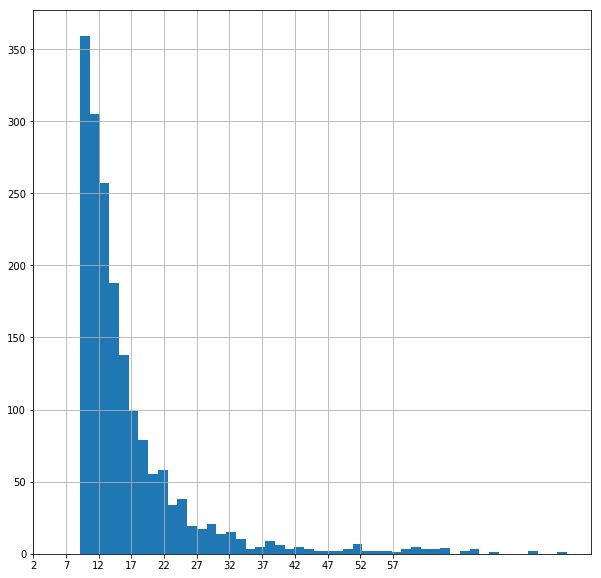

In [12]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10))
hist = df['decision_function'].nlargest(len(df) // 500)
plt.hist(hist, bins=50)
plt.grid()
plt.xticks(np.arange(2, 60, 5))
plt.show()

### Select optimal threshold

In [ ]:
st_id = generate_station_id
window = pd.Timedelta('2h')
generated_results = []

for thresh in np.arange(2, 10, 0.2):
    df['label_predict'] = df['decision_function'] > thresh
        
    recall = calc_recall(df, st_id, window)
    precision = calc_precision(df, st_id, window)
    f1 = calc_f1_score(precision, recall)
    
    generated_results.append({'Threshold': thresh, 'F1': f1 ,'Recall': recall, 'Precision': precision,})
    print("Threshhold: {0:.3f} -- {1:.3f}, {2:.3f}, {3:.3f}".format(thresh, f1, recall, precision))
    

## Predict values

In [13]:
y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)

## Decision Function

In [14]:
threshold = 3.7
df_train['predict_t_road'] = y_train_pred
df_train['label_predict'] = np.abs(y_train - y_train_pred) > threshold
num_of_outliers = len(df_train[df_train['label_predict']])
percentage = num_of_outliers / len(df_train)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_train)))
print(df_train.groupby('station_id')['label_predict'].sum())

Ratio of anomalies is 0.00013% (214 out of 1605928)
station_id
113      11.0
115       0.0
116       1.0
118      11.0
126       7.0
150       1.0
152       1.0
200       0.0
223       8.0
228      17.0
239       9.0
305       2.0
308       2.0
309      36.0
401       7.0
411       7.0
432      13.0
435       2.0
454       9.0
456      31.0
593       3.0
1831      9.0
1838      2.0
1899      4.0
1911      4.0
4007      4.0
20323     0.0
20717     0.0
20743     3.0
20754     1.0
20755     0.0
20761     2.0
20916     4.0
20921     3.0
Name: label_predict, dtype: float64


In [15]:
threshold = 3.7
df_test['predict_t_road'] = y_pred
df_test['label_predict'] = np.abs(y_test - y_pred) > threshold
num_of_outliers = len(df_test[df_test['label_predict']])
percentage = num_of_outliers / len(df_test)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_test)))
print(df_test.groupby('station_id')['label_predict'].sum())

Ratio of anomalies is 0.00070% (680 out of 972869)
station_id
114      23.0
117      86.0
119      16.0
302      30.0
303      30.0
307     203.0
393      24.0
442      19.0
503      20.0
504      21.0
511      36.0
516      51.0
628      32.0
1896     63.0
1921     26.0
Name: label_predict, dtype: float64


In [21]:
df = copy(df_test)
df = df[df['station_id']==1896]
df[df['label_predict']]

,date_time_utc,station_id,id_t_road,data_latitude,data_longitude,data_solar_altitude,data_solar_azimuth,data_t_air,data_t_air_lag_20,data_t_air_lag_40,...,data_dampness_diff_40_60,data_dampness_diff_60_80,data_dampness_diff_80_100,data_dampness_diff_100_120,data_dayofyear_cos,data_dayofyear_sin,data_hour_cos,data_hour_sin,predict_t_road,label_predict
870985,2013-09-01 00:00:00,1896,2.133447e+08,54.447,53.603,-0.024192,-1.372116,7.633333,15.000000,15.350000,...,-1.883333,0.166667,-1.783333,-4.116667,-0.504961,0.863142,1.000000e+00,0.000000,14.546847,True
872219,2013-09-19 10:40:00,1896,2.196783e+08,54.447,53.603,0.374400,0.141184,15.372078,11.927922,11.902597,...,0.207143,0.207143,0.207143,0.207143,-0.632103,0.774884,2.588190e-01,0.965926,14.457417,True
872305,2013-09-23 07:00:00,1896,2.211385e+08,54.447,53.603,-0.078742,1.255490,6.085714,14.314286,14.357143,...,-0.200000,-0.200000,-0.200000,-0.200000,-0.658402,0.752667,6.087614e-01,0.793353,17.901092,True
886211,2014-04-04 13:00:00,1896,3.294887e+08,54.447,53.603,0.707972,-0.951170,-1.238720,-9.461280,-9.487805,...,0.136280,0.136280,0.136280,0.136280,0.690173,0.723644,-1.305262e-01,0.991445,-7.416320,True
890045,2014-05-26 01:20:00,1896,3.677695e+08,54.447,53.603,-0.210195,3.072005,-0.066667,-0.050000,0.000000,...,-0.166667,-0.666667,-2.666667,-2.166667,0.309017,0.951057,9.914449e-01,0.130526,1.652434,True
890046,2014-05-26 01:40:00,1896,3.677851e+08,54.447,53.603,-0.211649,-3.129307,-0.033333,-0.066667,-0.050000,...,0.283333,-0.166667,-0.666667,-2.666667,0.309017,0.951057,9.914449e-01,0.130526,14.510190,True
890048,2014-05-26 02:20:00,1896,3.678002e+08,54.447,53.603,-0.202071,-2.961875,0.033333,0.000000,-0.033333,...,0.100000,0.550000,0.283333,-0.166667,0.309017,0.951057,9.659258e-01,0.258819,27.362975,True
890489,2014-09-01 00:00:00,1896,4.435213e+08,54.447,53.603,0.038199,1.474765,3.700000,6.500000,6.933333,...,0.000000,-0.050000,-0.783333,-0.733333,-0.504961,0.863142,1.000000e+00,0.000000,10.967905,True
890629,2014-09-03 10:00:00,1896,4.450034e+08,54.447,53.603,0.268827,1.099007,11.000000,14.416667,14.433333,...,-0.150000,-0.150000,-0.150000,-0.150000,-0.519744,0.854322,2.588190e-01,0.965926,18.344040,True
910249,2015-09-01 00:00:00,1896,8.151967e+08,54.447,53.603,0.287395,-1.137470,9.433333,10.966667,11.700000,...,-6.133333,-1.433333,-2.133333,-1.366667,-0.504961,0.863142,1.000000e+00,0.000000,14.929318,True


## Plot result

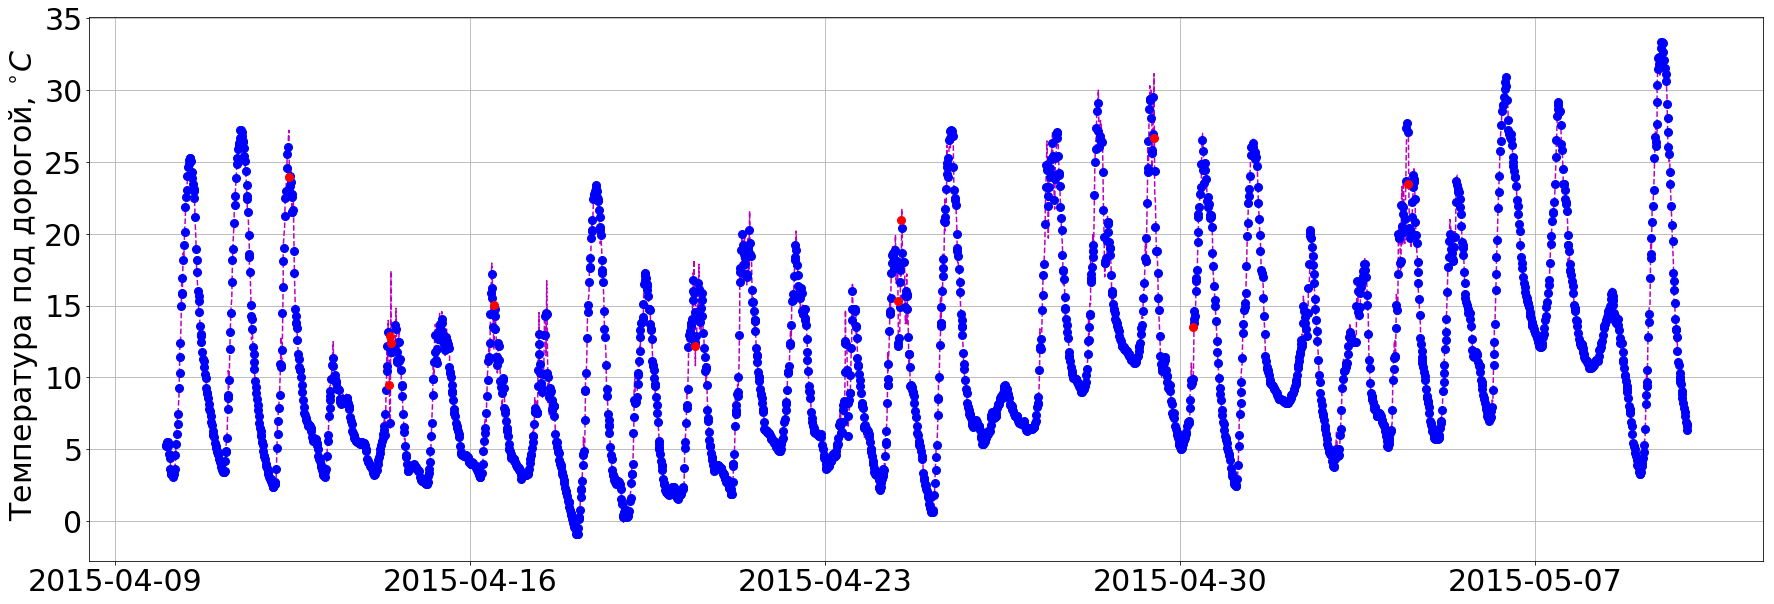

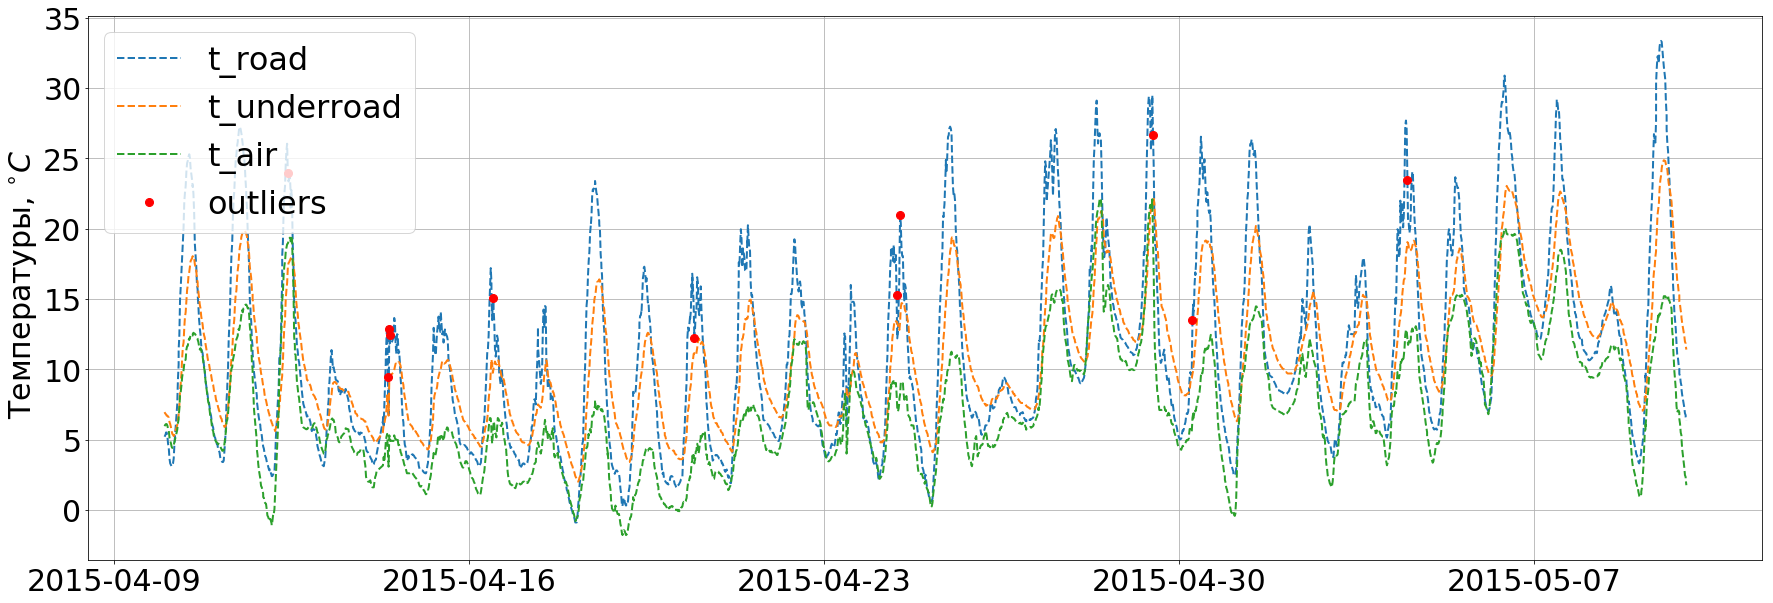

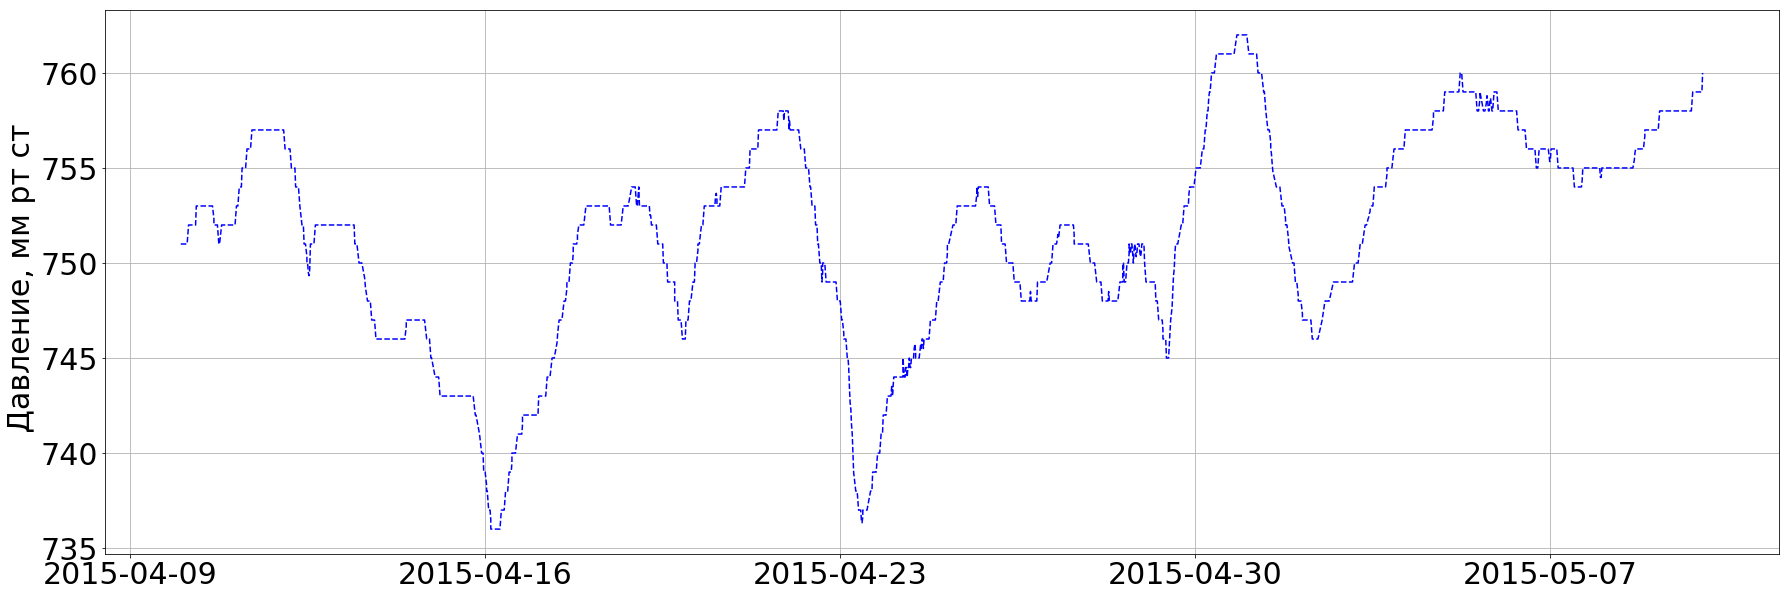

In [107]:
import matplotlib.pyplot as plt

#####-----------------------------STATION_ID-------------------------------#####
z = copy(df_test[df_test['station_id']==1921].set_index('date_time_utc'))
#z = copy(df_train[df_train['station_id']==228].set_index('date_time_utc'))

#####-----------------------------TIME_INTERVAL-------------------------------#####
start = pd.Timestamp(2015, 4, 10)
end = pd.Timestamp(2015, 5, 10)
to_plot = z[(z.index<=end) & (z.index>=start)]

#####-----------------------------T_AIR-------------------------------#####
plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['predict_t_road'], 'm',
                      linestyle='--', marker='None', markersize=8, label='predicted T_road')

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='true T_road')
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Температура под дорогой, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)


#####-----------------------------TEMPERATURE-------------------------------#####
plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot.index, to_plot['target_t_road'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_road')
        
        plt.plot_date(to_plot.index, to_plot['data_t_underroad'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_underroad')
        
        plt.plot_date(to_plot.index, to_plot['data_t_air'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_air')
        
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температуры, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)

#####-----------------------------PRESSURE-------------------------------#####
plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['data_pressure'], 'b',
                      linestyle='--', marker='None', markersize=8, label='pressure')


plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Давление, мм рт ст', fontsize=30)

plt.tick_params(labelsize=30)

plt.show()